In [1]:
import os
import flopy
import matplotlib.pyplot as plt
from flopy.plot import PlotMapView
from flopy.utils.triangle import Triangle
from flopy.utils.voronoi import VoronoiGrid
from flopy.discretization import VertexGrid
import numpy as np
import geopandas as gpd
from shapely.geometry import LineString
import shapefile
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

from dem_conditioning import fill_sinks, fill_nan_values
from flow_directions import FlowDirections
from stream_util import PrmsStreams

from gsflow.builder import GenerateFishnet

C:\Users\jlarsen\Documents\anaconda3\lib\site-packages\matplotlib\__init__.py:152: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
C:\Users\jlarsen\Documents\anaconda3\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
C:\Users\jlarsen\Documents\anaconda3\lib\site-packages\matplotlib\__init__.py:152: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
C:\Users\jlarsen\Documents\anaconda3\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
C:\Users\jlarsen\Documents\anaconda3\lib\site-packages\matplotlib\__init__.py:152: DeprecationWarning: distutils Version

In [2]:
ws = os.path.join(".")
dem_file = os.path.join(ws, "data", "dem.img")
pour_point = os.path.join(ws, "data", "model_points.shp")

Generate a `StructuredGrid` instance via pyGSFLOW's `GenerateFishnet` class 

In [3]:
cellsize = 50
sgrid = GenerateFishnet(dem_file, xcellsize=cellsize, ycellsize=cellsize)
sgrid

xll:214270.0; yll:4366610.0; rotation:0.0; units:undefined; lenuni:0

Use FloPy's `Raster` class to resample the DEM to the model grid

In [4]:
rstr = flopy.utils.Raster.load(dem_file)
dem = rstr.resample_to_grid(sgrid, rstr.bands[0], method="min")
dem[dem == rstr.nodatavals[0]] = np.nan

C:\Users\jlarsen\Documents\anaconda3\lib\site-packages\rasterstats\io.py:17: DeprecationWarning: ReadingError is deprecated and will be removed in a future version. Use ShapelyError instead (functions previously raising {name} will now raise a ShapelyError instead).
  from shapely.errors import ReadingError


Condition the DEM and run flow accumulation

In [5]:
conditioned_dem = fill_sinks(sgrid, dem)
fdir = FlowDirections(sgrid, conditioned_dem)
facc = fdir.flow_accumulation()

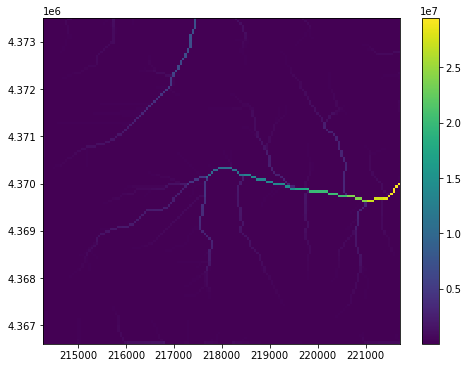

In [6]:
fig, ax = plt.subplots(figsize=(8, 6))
pmv = PlotMapView(modelgrid=sgrid, ax=ax)
lfacc = np.log10(facc)
pc = pmv.plot_array(facc)
# pmv.plot_grid()
plt.colorbar(pc);

Read in the gage location at the end of the basin and delineate the watershed

In [7]:
gdf = gpd.read_file(pour_point)
pploc = gdf.geometry.values[0]
type(pploc)
pploc.__geo_interface__

{'type': 'Point', 'coordinates': (221298.4058475063, 4369674.979622432, 0.0)}

In [8]:
watershed = fdir.get_watershed_boundary(pploc)
print(facc.shape, watershed.shape)
facc[watershed == 0] = np.nan

(138, 149) (138, 149)


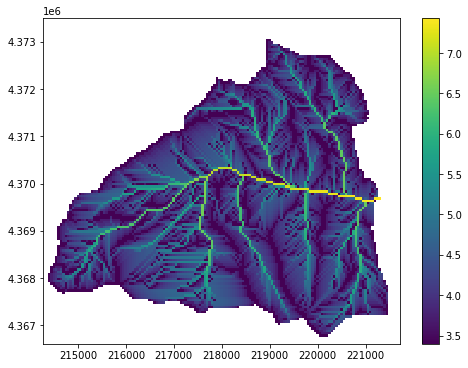

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))
pmv = PlotMapView(modelgrid=sgrid, ax=ax)
lfacc = np.log10(facc)
pc = pmv.plot_array(lfacc)
# pmv.plot_grid()
plt.colorbar(pc);

Delineate the structured stream locations and create vectors

In [10]:
strms = PrmsStreams(sgrid, fdir)
strm_array = strms.delineate_streams(contrib_area=810000).astype(float)
strm_array[watershed == 0] = np.nan
vectors = strms.create_stream_vectors(strm_array)

Plot these vectors with the stream array

In [11]:
geom = [LineString(v) for v in vectors.values()]
segs = [k for k in vectors.keys()]
gdf = gpd.GeoDataFrame({"geometry": geom, "segments": segs})
gdf = gdf.dissolve()
gdf["geometry"] = gdf.geometry.buffer(50, cap_style=2, join_style=3)

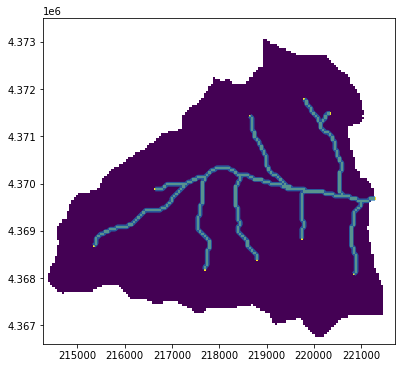

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))
pmv = PlotMapView(modelgrid=sgrid, ax=ax)
strm_array[watershed == 0] = np.nan
pc = pmv.plot_array(strm_array)
gdf.plot(ax=ax, alpha=0.75);

Create a geodataframe of the active watershed and dissolve it

In [13]:
sgdf = sgrid.geo_dataframe
iloc = np.where(watershed.ravel() > 0)[0]
sgdf = sgdf.iloc[iloc]
sgdf = sgdf.dissolve()

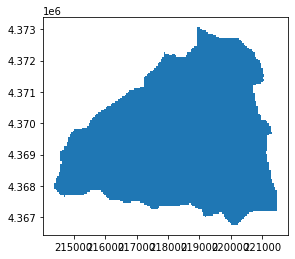

In [14]:
sgdf.plot();

Trim the buffered stream vectors by overlaying with the active watershed

In [15]:
igdf = gpd.overlay(gdf, sgdf, how="intersection")

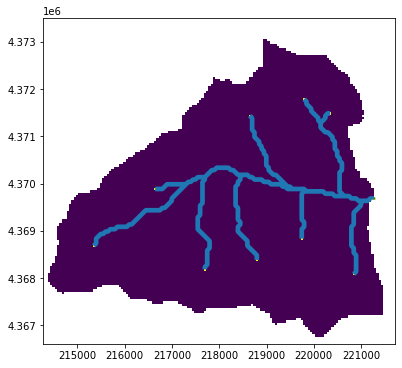

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))
pmv = PlotMapView(modelgrid=sgrid, ax=ax)
strm_array[watershed == 0] = np.nan
pc = pmv.plot_array(strm_array)
igdf.plot(ax=ax);

Generate a triangular mesh using the `Triangle` module

Note: Must define a watershed point `wsloc` and a stream refinement point `srloc`

In [17]:
wsloc = (220000, 4368000)
srloc = (219250, 4370000)

In [18]:
tri_ws = os.path.join(ws, "data", "sagehen_tri_grid")
tri = flopy.utils.triangle.Triangle(angle=30, model_ws=tri_ws)
tri.add_polygon(sgdf.geometry.values[0])
tri.add_polygon(gdf.geometry.values[0], ignore_holes=True)
tri.add_region(wsloc, 0, maximum_area=100*100*3)
tri.add_region(srloc, 1, maximum_area=40*40)
tri.build()

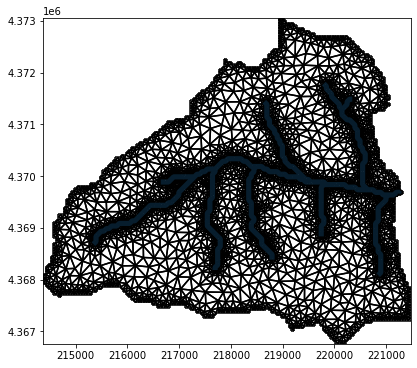

In [19]:
fig, ax = plt.subplots(figsize=(8, 6))
tri.plot(ax=ax)
igdf.geometry.plot(ax=ax, alpha=0.25, zorder=5);

Now generate a voronoi mesh from the triangular mesh

In [20]:
vor = VoronoiGrid(tri)
gridprops = vor.get_gridprops_vertexgrid()
vgrid = VertexGrid(nlay=1, **gridprops)

verts = np.array(gridprops["vertices"])[:, 1:]

check = np.unique(verts, axis=0)

if verts.shape != check.shape:
    # duplicate vertices!!!!! We need to fix this somehow!
    # potentially create a search and replace operation. It seems likely that some voronoi cells have duplicate verts.
    print(verts.shape, check.shape)

(9637, 2) (9021, 2)


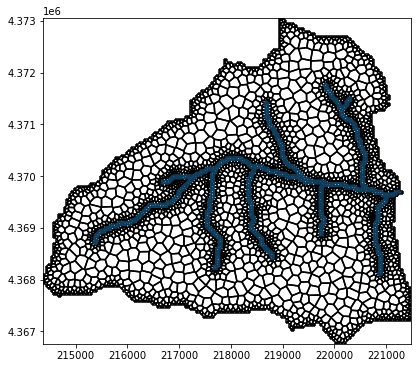

In [21]:
fig, ax = plt.subplots(figsize=(8, 6))
pmv = PlotMapView(modelgrid=vgrid, ax=ax)
pmv.plot_grid(color="k")
igdf.geometry.plot(ax=ax, alpha=0.50, zorder=5);

Now we can begin the process of performing raster resampling and flow accumulation on the voronoi grid

In [22]:
raster = flopy.utils.Raster.load(dem_file)
dem = raster.resample_to_grid(vgrid, band=raster.bands[0], method="min")
dem = np.where(dem == raster.nodatavals[0], np.nan, dem)

xy = list(zip(*pploc.coords.xy))[0]
ppnode = vgrid.intersect(*xy)
dem[ppnode] = np.nanmin(dem) - 1

In [23]:
filled_dem = fill_nan_values(vgrid, dem)
conditioned_dem = fill_sinks(vgrid, filled_dem)

# perform area based flow accumulation
fdir = FlowDirections(vgrid, conditioned_dem)
facc = fdir.flow_accumulation()
# perform cellular flow accumulation
fdir2 = FlowDirections(vgrid, conditioned_dem)
facc2 = fdir2.flow_accumulation(as_cells=True)

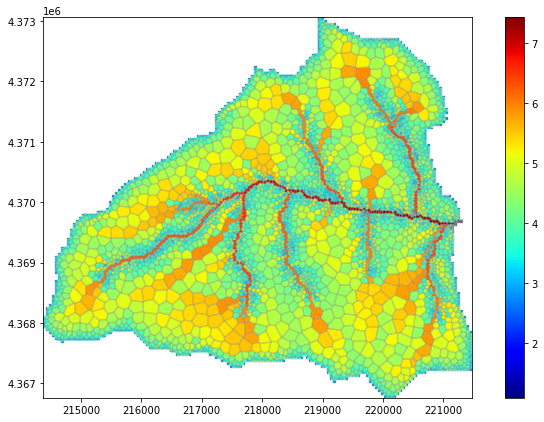

In [24]:
fig, ax = plt.subplots(figsize=(12, 7))
pmv = PlotMapView(modelgrid=vgrid)
lfacc = np.log10(facc)
pc = pmv.plot_array(lfacc, cmap="jet")
# pc = pmv.plot_array(conditioned_dem, alpha=1.0, cmap="jet", vmin=1900, vmax=2000)
pmv.plot_grid(alpha=0.2)
plt.colorbar(pc);

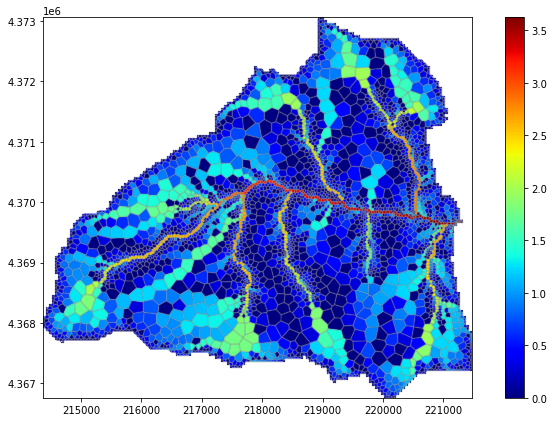

In [25]:
fig, ax = plt.subplots(figsize=(12, 7))
pmv = PlotMapView(modelgrid=vgrid)
lfacc2 = np.log10(facc2)
pc = pmv.plot_array(lfacc2, alpha=1.0, cmap="jet")
pmv.plot_grid(alpha=0.2)
plt.colorbar(pc);